> __Purpose:__ This NB takes forever to run. The functionality of this ended up being to create and plot the results, and then I saved the results so that I could use them in a fresh new NB without all this code and crazy run times.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
import os
import h5py
import copy

import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import re
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score

#import warnings
#warnings.filterwarnings("ignore")

random.seed(a=1)

In [2]:
#import sys

# Add grandparent directory to the system path
#grandparent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
#print(grandparent_dir)
#sys.path.append(grandparent_dir)

# Import the modules
#from fl_sim_client import *
#from fl_sim_server import *
#from presentation_sns_config import *


In [3]:
final_update = 16

## Load Data

In [6]:
def load_final_model_performances(cv_results_path, filename, num_clients=14, num_folds=7, verbose=False):
    extraction_dict = dict()
    for i in range(num_folds):
        h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
        #print(h5_path)
        
        # Load data from HDF5 file
        with h5py.File(h5_path, 'r') as f:
            a_group_key = list(f.keys())
            #if i==0:
            #    print(a_group_key)
            for key in a_group_key:
                #print(key)
        
                if key=="client_local_model_log":
                    client_keys = list(f[key])
                    #print(client_keys)
                    for ck in client_keys:
                        ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                        #print(f"Key: {key}, Client: {ck}, Fold: {i}")
    
                        # So this doenst have any knoledge of the fold number???
                        if len(list(f[key][ck]))==0:
                            #print(f"{ed_key} SKIPPED!")
                            pass
                        else:
                            #print(f"{ed_key} SUCCESS!")
                            extraction_dict[ed_key] = list(f[key][ck])
                elif key=="global_model_log" and "NOFL" not in filename:
                    # Do I need to turn this off for NoFL? Or will it just be empty and append something empty...
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                else:
                    pass

    return extraction_dict


In [11]:
NUM_PLOTTED_CONDITIONS = 6
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 14
NUM_FOLDS = 5

results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSims'
base_path = results_path + current_directory

# CROSS
cpfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
cfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-25_FEDAVG', 'GDLS_FEDAVG_KFold')
cnofl_model_dict = load_final_model_performances(base_path+r'\09-19_23-30_NOFL', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
ipfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-05_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
ifa_model_dict = load_final_model_performances(base_path+r'\09-19_23-04_FEDAVG', 'GDLS_FEDAVG_KFold')
inofl_model_dict = load_final_model_performances(base_path+r'\09-19_22-56_NOFL', 'FULLSCIPYMIN_NOFL_KFold')


In [12]:
cpfa_model_dict.keys()

dict_keys(['S0_client_local_model_log_fold0', 'S10_client_local_model_log_fold0', 'S11_client_local_model_log_fold0', 'S12_client_local_model_log_fold0', 'S13_client_local_model_log_fold0', 'S1_client_local_model_log_fold0', 'S2_client_local_model_log_fold0', 'S3_client_local_model_log_fold0', 'S4_client_local_model_log_fold0', 'S5_client_local_model_log_fold0', 'S6_client_local_model_log_fold0', 'S7_client_local_model_log_fold0', 'S8_client_local_model_log_fold0', 'S9_client_local_model_log_fold0', 'S0_client_local_model_log_fold1', 'S10_client_local_model_log_fold1', 'S11_client_local_model_log_fold1', 'S12_client_local_model_log_fold1', 'S13_client_local_model_log_fold1', 'S1_client_local_model_log_fold1', 'S2_client_local_model_log_fold1', 'S3_client_local_model_log_fold1', 'S4_client_local_model_log_fold1', 'S5_client_local_model_log_fold1', 'S6_client_local_model_log_fold1', 'S7_client_local_model_log_fold1', 'S8_client_local_model_log_fold1', 'S9_client_local_model_log_fold1', '

## No-FL Case

In [17]:
extractration_dict = copy.deepcopy(inofl_model_dict)
keys = extractration_dict.keys()
num_updates = len(extractration_dict[list(extractration_dict.keys())[0]])
print(f"{num_updates} unique models")

# Initialize a list of empty DataFrames for each user group
dec_flattened_list = [pd.DataFrame(columns=['Subject', 'Fold', 'Update Number', 'Flattened Dec']) for _ in range(num_updates)]

# Regular expression pattern to extract subject and fold
#pattern = r"S(\d+)_client_local_model_log_fold(\d+)"
pattern = r"(S\d+)_client_local_model_log_fold(\d+)"

# Loop through keys and updates to populate the DataFrames
for key_idx, key in enumerate(keys):
    match = re.search(pattern, key)  # Extract the subject and fold using regex
    if match:
        #subject = int(match.group(1))  # e.g., '0', '1', '10'
        subject = match.group(1)  # e.g., 'S0', 'S1', 'S10'
        fold = int(match.group(2))  # e.g., '0', '1', '2'
        
        for update_number in range(num_updates): 
            #for i in range(NUM_CLIENTS):  # Loop through all users
            user_data = np.ravel(extractration_dict[key][update_number])
            dec_flattened_list[update_number].loc[len(dec_flattened_list[update_number])] = [subject, fold, update_number, user_data]

# Concat all the dfs into a single training input dataframe
dec_flattened = pd.concat(dec_flattened_list, ignore_index=True, axis=0)

# Expand the 'Flattened Dec' column into individual columns
expanded_dec_df = dec_flattened.join(dec_flattened['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)

# Display the shape and a preview of the expanded dataframe
print(expanded_dec_df.shape)
expanded_dec_df.head()


13 unique models
(1274, 131)


,Subject,Fold,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,S0,0,0,0.17709,0.539352,0.551883,0.630438,0.728862,0.571867,0.960688,...,0.958434,0.263781,0.385073,0.080152,0.269549,0.908628,0.833235,0.886523,0.200153,0.914273
1,S10,0,0,0.17709,0.539352,0.551883,0.630438,0.728862,0.571867,0.960688,...,0.958434,0.263781,0.385073,0.080152,0.269549,0.908628,0.833235,0.886523,0.200153,0.914273
2,S11,0,0,0.17709,0.539352,0.551883,0.630438,0.728862,0.571867,0.960688,...,0.958434,0.263781,0.385073,0.080152,0.269549,0.908628,0.833235,0.886523,0.200153,0.914273
3,S12,0,0,0.17709,0.539352,0.551883,0.630438,0.728862,0.571867,0.960688,...,0.958434,0.263781,0.385073,0.080152,0.269549,0.908628,0.833235,0.886523,0.200153,0.914273
4,S13,0,0,0.17709,0.539352,0.551883,0.630438,0.728862,0.571867,0.960688,...,0.958434,0.263781,0.385073,0.080152,0.269549,0.908628,0.833235,0.886523,0.200153,0.914273


# Adversarial Modeling

In [126]:
# LinearSVC() --> Was failling to converge...

In [34]:
def make_all_update_models(flattened_input_df, n_start_stop, num_kfolds=7, stratification=False, i_modulus=3, i_lt_or_eq='eq', 
                           my_metrics_columns=['Algorithm', 'Update Number', 'CV Acc', 'Test Acc'], 
                           my_models_list=[KNeighborsClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], 
                           make_df=True, full_test_df=pd.DataFrame()):

    full_test_res_df = pd.DataFrame(columns=my_metrics_columns)

    # Adjust stop index to prevent overflow
    n_stop = n_start_stop[1] - 1

    for i in range(n_start_stop[0], n_stop + 1):
        print(f"Round i={i} of stop={n_start_stop[1]}")

        if make_df:
            #print("Making custom test set, NOT USING PASSED IN full_test_df")

            if i%i_modulus==0:
                # Filter the dataframe to use data from updates <= i
                # TODO: DECIDE ON USING <, <=, OR BOTH!
                if i_gt_or_eq == 'lt':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] <= i]
                elif i_gt_or_eq == 'eq':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] == i]
                test_df = flattened_input_df[flattened_input_df['Update Number'] == n_stop]  # Hold out the last update for testing
            else:
                # SKIP THE ENTIRE LOOP
                print(f"{i} skipped for speed!")
                continue
        else:
            raise ValueError('Need to set train_df somehow...: for now, only use make_df=True')
            test_df = full_test_df  

        X_train = train_df.drop(columns=['Subject', 'Fold', 'Update Number'])
        y_train = train_df['Subject']
        
        X_test = test_df.drop(columns=['Subject', 'Fold', 'Update Number'])
        y_test = test_df['Subject']

        # Explicitly use the 'Fold' column for cross-validation
        for model in my_models_list:
            cv_scores = []
            for fold_num in range(num_kfolds):
                #print(f"Fold {fold_num}")
                train_fold = train_df[train_df['Fold'] != fold_num]
                val_fold = train_df[train_df['Fold'] == fold_num]

                X_train_fold = train_fold.drop(columns=['Subject', 'Fold', 'Update Number']).reset_index(drop=True)
                y_train_fold = train_fold['Subject'].reset_index(drop=True)
                #print(f"y_train_fold: {y_train_fold.unique()}")
                #print(y_train_fold)
                #print(type(y_train_fold))
                #print(type(y_train_fold.iloc[0]))

                X_val_fold = val_fold.drop(columns=['Subject', 'Fold', 'Update Number'])
                y_val_fold = val_fold['Subject']

                #print(f"X_val_fold.shape: {X_val_fold.shape}")
                #print(f"y_val_fold.shape: {y_val_fold.shape}")
                #print('y_val_fold')
                #for value, count in y_val_fold.value_counts().items():
                #    print(f"{value}: {count}")
                #print()

                # Fit model on the current training fold
                model.fit(X_train_fold, y_train_fold)

                # Evaluate on the validation fold
                score = model.score(X_val_fold, y_val_fold)
                cv_scores.append(score)

            # After evaluating all folds, calculate the average cross-validation score
            cv_avg_score = sum(cv_scores) / len(cv_scores)

            # Calculate the test accuracy on the hold-out test set
            test_acc = model.score(X_test, y_test)

            # Save the results to the full_test_res_df DataFrame
            new_row = pd.DataFrame({
                'Algorithm': [type(model).__name__],
                'Update Number': [i],
                'CV Acc': [cv_avg_score],
                'Test Acc': [test_acc]
            })
            full_test_res_df = pd.concat([full_test_res_df, new_row], ignore_index=True)

    return full_test_res_df


In [32]:
full_test_res_df = make_all_update_models(expanded_dec_df, n_start_stop=(0, num_updates))


Round i=0 of stop=13
Round i=1 of stop=13
1 skipped for speed!
Round i=2 of stop=13
2 skipped for speed!
Round i=3 of stop=13
Round i=4 of stop=13
4 skipped for speed!
Round i=5 of stop=13
5 skipped for speed!
Round i=6 of stop=13
Round i=7 of stop=13
7 skipped for speed!
Round i=8 of stop=13
8 skipped for speed!
Round i=9 of stop=13
Round i=10 of stop=13
10 skipped for speed!
Round i=11 of stop=13
11 skipped for speed!
Round i=12 of stop=13


In [33]:
full_test_res_df

,Algorithm,Update Number,CV Acc,Test Acc
0,KNeighborsClassifier,0,0.071429,0.071429
1,DecisionTreeClassifier,0,0.071429,0.071429
2,GradientBoostingClassifier,0,0.071429,0.071429
3,KNeighborsClassifier,3,1.000000,0.081633
4,DecisionTreeClassifier,3,0.948980,0.071429
5,GradientBoostingClassifier,3,0.979592,0.071429
6,KNeighborsClassifier,6,1.000000,0.346939
7,DecisionTreeClassifier,6,0.908163,0.071429
8,GradientBoostingClassifier,6,0.979592,0.071429
9,KNeighborsClassifier,9,0.969388,0.959184


In [37]:
knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

In [39]:
print(knn_df.shape)
knn_df.head()

(5, 4)


,Algorithm,Update Number,CV Acc,Test Acc
0,KNeighborsClassifier,0,0.071429,0.071429
3,KNeighborsClassifier,3,1.000000,0.081633
6,KNeighborsClassifier,6,1.000000,0.346939
9,KNeighborsClassifier,9,0.969388,0.959184
12,KNeighborsClassifier,12,0.959184,0.959184


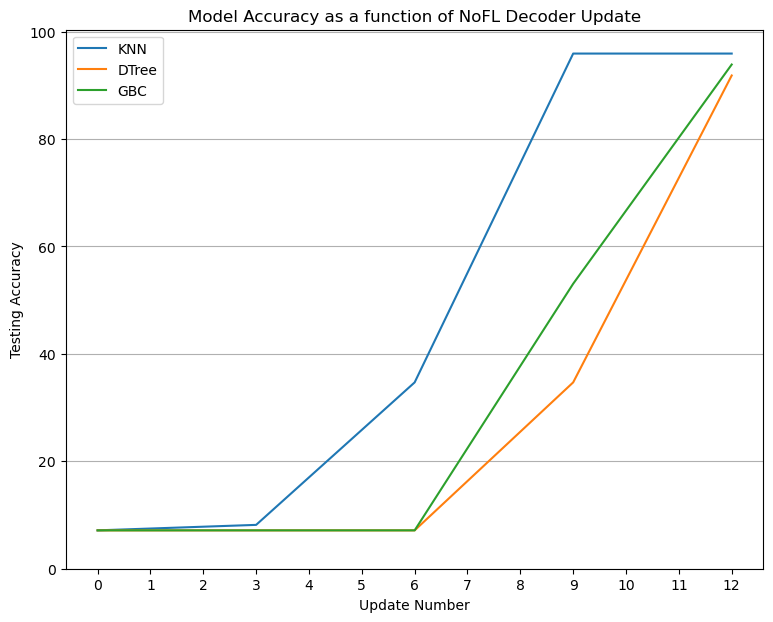

In [42]:
col_num = 1
my_x_updates = list(range(17))

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [ ]:
assert(False)

In [ ]:
# RENAME / REWORK THESE!

global_lr_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='LogisticRegression()']
global_knn_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='KNeighborsClassifier()']
global_svc_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='LinearSVC()']
global_sgd_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='SGDClassifier()']
global_dt_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='DecisionTreeClassifier()']
global_gbt_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='GradientBoostingClassifier()']